# Analysis of 6F vs. NIL sorted based on CellTrace-low on 4 dpi

Notes:

1. Only singlets are included
2. Replated at 4 dpi at 10k/96-well
3. These were CTFR stained at 1 dpi, 1:1000 (1 µM) for 30 min at 37C, then washed with DMEM/FBS 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import re
from pathlib import Path

# Required descriptors for annotate
from scipy.stats import ttest_ind
from statannotations.stats.StatTest import StatTest
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

custom_long_name = 't-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_less'
custom_func = ttest_ind
ttest_ind_less = StatTest(custom_func, custom_long_name, custom_short_name, alternative='less')

# 4 dpi data
## Load data

In [2]:
# List of ctrls
ctrl_list = ['Ctrl-neg', 'Ctrl-NILDDRR', 'Ctrl-puro']

# Store all data in list of dfs which will be converted to df at end
data = list()
ctrl_data = list()

# Load first set of data
base_datadir = rd.datadir/'2022.08.08_NIL_v_6F_sort_1-3'
figpath = '../figures/fig3/'
# List of data folder names
dir_list = ['2022.08.08_NIL_v_6F_sort_1', '2022.10.13_NIL_v_6F_sort_2', '2022.10.18_NIL_v_6F_sort_3']
for (j, dir_name) in enumerate(dir_list):

    datadir = base_datadir/dir_name/'export_P3'
    files = Path(datadir).glob('*.csv') 

    for i, file in enumerate(files):

        # Extract metadata from csv title
        match = re.search(
            'export_(?P<subsetName>.+)_(?P<cond>.+).csv', file.name)
        # If no match, keep going
        if match is None:
            print('No match for {}'.format(file.name))
            continue

        # Load as df and note header is on 0th row
        df = pd.read_csv(file, header=0)

        # Update columns in df with metadata from file name
        df['cond'] = match.group('cond')
        df['replicate'] = int(dir_name[-1])

        if match.group('cond') in ctrl_list:
            ctrl_data.append(df)
            # Add ctrl-puro to main data too
            if match.group('cond') == 'Ctrl-puro':
                data.append(df)
        else:
            data.append(df)

# Load second set of data
datadir = rd.datadir/'2024.08.30_NILDDRR-sort_1-3'/'export_P3'
files = Path(datadir).glob('*.csv') 
for i, file in enumerate(files):

    # Extract metadata from csv title
    match = re.search(
        'export_Specimen_001_(?P<cond>.+)_(?P<rep>.+)_P3.csv', file.name)
    # If no match, keep going
    if match is None:
        print('No match for {}'.format(file.name))
        continue

    # Load as df and note header is on 0th row
    df = pd.read_csv(file, header=0)

    # Update columns in df with metadata from file name
    df['cond'] = match.group('cond')
    df['replicate'] = int(match.group('rep'))+3

    if match.group('cond') in ctrl_list:
        ctrl_data.append(df)
        # Add ctrl-puro to main data too
        if match.group('cond') == 'Ctrl-puro':
            data.append(df)
    else:
        data.append(df)


# Convert list of dfs into single df
data = pd.concat(data, ignore_index=True)
ctrl_data = pd.concat(ctrl_data, ignore_index=True)

# Remove negative data
data = data.loc[
    (data['APC-A'] > 0) &
    (data['FITC-A'] > 0)
]
ctrl_data = ctrl_data.loc[
    (ctrl_data['APC-A'] > 0) &
    (ctrl_data['FITC-A'] > 0)
]

## Categorize cells based on CellTrace-FarRed (APC)

In [3]:
# Get APC-low threshold for each rep s.t.
# APC_low_thresh = 20% dimmest in ctrl
rep_list = data.replicate.unique()
APC_low_thresh_list = np.zeros(np.shape(rep_list))
for (i, rep) in enumerate(rep_list):
    APC_low_thresh_list[i] = np.percentile(
        ctrl_data.loc[(ctrl_data['cond'] == 'Ctrl-puro') &
            (ctrl_data['replicate'] == rep)
        ]['APC-A'], 20)

# Categorize based on APC for each replicate
data['APC_cat'] = None
for (i, rep) in enumerate(rep_list):
    data.loc[
        (data['replicate'] == rep_list[i]) &
        (data['APC-A'] <= APC_low_thresh_list[i]),
        'APC_cat'] = 'APC-low'
    data.loc[
        (data['replicate'] == rep_list[i]) &
        (data['APC-A'] > APC_low_thresh_list[i]),
        'APC_cat'] = 'non-APC-low'


# Calculate APC populations using these metrics
well_group = ['cond', 'replicate']
count_df = data.groupby([*well_group, 'APC_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if none rather than dropping row
APC_df = (count_df*100/count_df.groupby(['cond', 'replicate']
                           ).transform('sum')).dropna().reset_index(name='percent')

## Categorize eGFP+ cells
### Define eGFP (FITC) cut-off

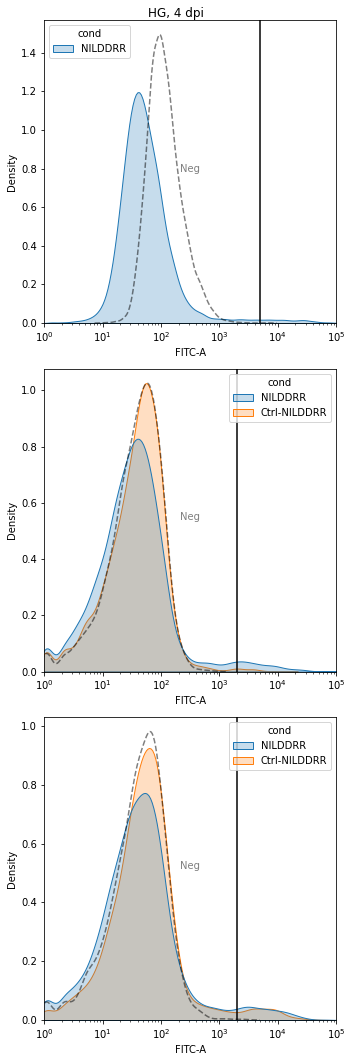

In [5]:
# Gather relevant data
FITC_data = [data.loc[(data['cond'] == 'NILDDRR')],
    ctrl_data.loc[(ctrl_data['cond'] == 'Ctrl-NILDDRR')]]
FITC_data = pd.concat(FITC_data, ignore_index=True)


# Threshold for iMNs
FITC_thresh_list = [5*10**3, 2*10**3, 2*10**3, 2*10**3, 2*10**3, 2*10**3]

fig, ax = plt.subplots(rep_list.size, 1, figsize=(5, 15))

# Plot FITC-A (eGFP)
x = 'FITC-A'
for (i, rep) in enumerate(rep_list):

    sns.kdeplot(data=FITC_data[FITC_data.replicate == rep],
            ax=ax[i], x=x, hue='cond',
            common_norm = False, log_scale=(True, False),
            fill=True, color='limegreen')
    ax[i].axvline(FITC_thresh_list[i], color='black')

    if i < 3:
        # Plot neg ctrl
        sns.kdeplot(data=ctrl_data[(ctrl_data['cond'] == 'Ctrl-neg') & (ctrl_data.replicate == rep)], x=x, common_norm=False,
                    ax=ax[i], log_scale=(True, False), color='black', fill=False, alpha=0.5, linestyle='--')
        ax[i].annotate('Neg', (0.5, 0.5), xycoords='axes fraction', alpha=0.5, ha='center')
    else:
        # Plot neg ctrl
        sns.kdeplot(data=ctrl_data[(ctrl_data['cond'] == 'Ctrl-neg') & (ctrl_data.replicate == 4)], x=x, common_norm=False,
                    ax=ax[i], log_scale=(True, False), color='black', fill=False, alpha=0.5, linestyle='--')
        ax[i].annotate('Neg', (0.5, 0.5), xycoords='axes fraction', alpha=0.5, ha='center')



# Title
plt.suptitle('HG, 4 dpi')
# Adjust limits
FITC_lim = (1, 1*10**5)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(FITC_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing
# plt.savefig(figpath + '4dpi_FITC_dist.svg', bbox_inches='tight')

In [6]:
# Categorize based on manually chosen FITC thresholds for each replicate
data['FITC_cat'] = None
for (i, rep) in enumerate(rep_list):
    data.loc[
        (data['replicate'] == rep_list[i]) &
        (data['FITC-A'] <= FITC_thresh_list[i]),
        'FITC_cat'] = 'FITC-'
    data.loc[
        (data['replicate'] == rep_list[i]) &
        (data['FITC-A'] > FITC_thresh_list[i]),
        'FITC_cat'] = 'FITC+'


# Calculate FITC populations using these metrics
well_group = ['cond', 'replicate']
count_df = data.groupby([*well_group, 'FITC_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no eGFP-H+ rather than dropping row
FITC_df = (count_df*100/count_df.groupby(well_group).transform('sum')).dropna().reset_index(name='percent')

### Plot eGFP+ percentages

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Ctrl-puro vs. 6F: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample), P_val:2.137e-01 Stat=-8.823e-01
6FDDRR vs. NIL: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample), P_val:5.544e-01 Stat=1.457e-01
NIL vs. NILDDRR: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample), P_val:9.208e-03 Stat=-3.843e+00
6F vs. 6FDDRR: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the firs

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the 

Text(0.5, 1.0, '4 dpi')

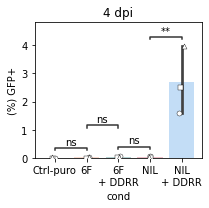

In [7]:
# Plotting params
x = 'cond'
marker_list = ['o', 's', '^', 'D', 'P', 'X']

# Conditions
cond_list = ['Ctrl-puro', '6F', '6FDDRR', 'NIL', 'NILDDRR']
colormap = {'Ctrl-puro': 'grey', '6F': 'coral',
            '6FDDRR': 'teal', 'NIL': 'crimson',
            'NILDDRR': 'dodgerblue'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))

# Plot hyperP percent
y = 'percent'
f = sns.barplot(ax=ax, data=FITC_df.loc[FITC_df['FITC_cat']=='FITC+'], x=x, y=y, order=cond_list,
            palette=colormap, alpha=0.3)
for (i, rep) in enumerate(FITC_df.replicate.unique()):
    sns.stripplot(ax=ax, data=FITC_df.loc[(FITC_df['FITC_cat']=='FITC+') & (FITC_df.replicate == rep)],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4,)

# Pairs for stats comp
pairs = [('Ctrl-puro', '6F'),
    ('6FDDRR', 'NIL'), ('NIL', 'NILDDRR'), ('6F', '6FDDRR')]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=FITC_df.loc[FITC_df['FITC_cat']=='FITC+'], x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_less, text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Format
f.set_xticklabels(['Ctrl-puro', '6F', '6F\n+ DDRR', 'NIL', 'NIL\n+ DDRR'])
ax.yaxis.set_label_text('(%) GFP+')

plt.title('4 dpi')

## Look at GFP+ of hyperP vs. non

In [8]:
# Calculate FITC populations using these metrics
well_group = ['cond', 'replicate']
count_df = data.groupby([*well_group, 'FITC_cat', 'APC_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no eGFP-H+ rather than dropping row
APC_FITC_percent = (count_df*100/count_df.groupby(well_group).transform('sum')).dropna().reset_index(name='percent')
# print(APC_FITC_percent.loc[APC_FITC_percent.FITC_cat=='FITC+'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

6FDDRR_non-APC-low vs. 6FDDRR_APC-low: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.000e+00 Stat=-5.358e-04
6F_non-APC-low vs. 6F_APC-low: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.000e+00 Stat=6.006e+00
NIL_non-APC-low vs. NIL_APC-low: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:6.981e-01 S

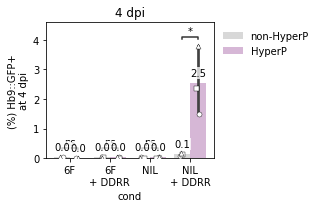

In [10]:
# Plotting params
x = 'cond'
hue = 'APC_cat'
hue_order = [ 'non-APC-low', 'APC-low']
marker_list = ['o', 's', '^', 'D', 'P', 'X']

# Conditions
cond_list = ['Ctrl-puro', '6F', '6FDDRR', 'NIL', 'NILDDRR']
cond_list = ['6F', '6FDDRR', 'NIL', 'NILDDRR']
colormap = {'non-APC-low': 'grey', 'APC-low': '#8b0288'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))

# Plot hyperP percent
y = 'percent'
f = sns.barplot(ax=ax, data=APC_FITC_percent.loc[APC_FITC_percent['FITC_cat']=='FITC+'],
    x=x, y=y, order=cond_list, hue=hue, hue_order=hue_order,  # capsize=.2, errwidth=2,
    palette=colormap, alpha=0.3)

for (i, rep) in enumerate(APC_FITC_percent.replicate.unique()):
    sns.stripplot(ax=ax, data=APC_FITC_percent.loc[(APC_FITC_percent['FITC_cat']=='FITC+') & (APC_FITC_percent.replicate == rep)],
        x=x, y=y, order=cond_list, hue=hue, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'non-APC-low': 'white', 'APC-low': 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)
    
# Pairs for stats comp
# pairs = [(('NILDDRR', 'APC-low'), ('NILDDRR', 'non-APC-low'))]
pairs = [((cond, 'APC-low'), (cond, "non-APC-low")) for cond in cond_list]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=APC_FITC_percent.loc[APC_FITC_percent['FITC_cat']=='FITC+'],
    x=x, y=y, pairs=pairs, hue=hue, order=cond_list, hue_order=hue_order)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Format
f.set_xticklabels(['6F', '6F\n+ DDRR', 'NIL', 'NIL\n+ DDRR'])
ax.yaxis.set_label_text('(%) Hb9::GFP+\nat 4 dpi')

plt.title('4 dpi')
# fig.tight_layout()  # Helps improve white spacing

# Adjust the legend
h,l = ax.get_legend_handles_labels()
lmap = {'APC-low':'HyperP', 'non-APC-low':'non-HyperP'}
plt.legend(h[-len(hue_order):], [lmap[i] for i in l[-len(hue_order):]],
           loc='best', title='Quadrant', bbox_to_anchor=(1,1), frameon=False)
sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))
# plt.savefig(figpath + '4dpi_FITC+_of_HyperP_percent-onedigit.svg', bbox_inches='tight')

# 14 dpi data

## Load data

In [16]:
# Directories
base_datadir = rd.datadir/'2022.08.18_NIL_v_6F_sort_1-3'

# List of data folder names
dir_list = ['2022.08.18_6F_v_NIL_CT-low-sort_14dpi_01', '2022.10.23_6F_v_NIL_CT-low-sort_14dpi_02', '2022.10.28_6F_v_NIL_CT-low-sort_14dpi_03']

# Store all data in list of dfs which will be converted to df at end
data_14dpi = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):

        # Load as df and note header is on 0th row
        df = rd.flow.load_csv_with_metadata(
            base_datadir/dir_name/'export_singlets', base_datadir/dir_name/'well_metadata.yaml')

        data_14dpi.append(df)

# Convert list of dfs into single df
data_14dpi = pd.concat(data_14dpi, ignore_index=True)

# Remove negative data
data_14dpi = data_14dpi.loc[
    (data_14dpi['eGFP-A'] > 0) &
    (data_14dpi['FSC-A'] > 0)
]

## Using just eGFP-H 

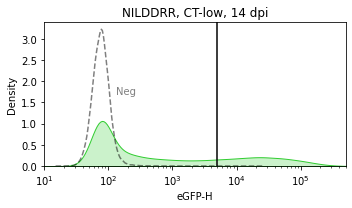

In [ ]:
# Threshold for iMNs
eGFP_H_thresh = 5*10**3

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot eGFP-H
x = 'eGFP-H'
sns.kdeplot(data=data_14dpi[(data_14dpi.cond == 'NILDDRR') & (data_14dpi.CT_cat == 'CT-low')],
            ax=ax, x=x,
            log_scale=(True, False), fill=True, color='limegreen')
ax.axvline(eGFP_H_thresh, 0, 1, color='black')

# Plot neg ctrl
sns.kdeplot(data=data_14dpi[(data_14dpi['cond'] == '6F') & (data_14dpi.CT_cat == 'non-CT-low')],
            x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='black', fill=False, alpha=0.5, linestyle='--')
ax.annotate('Neg', (0.27, 0.5), xycoords='axes fraction', alpha=0.5, ha='center')

# Title
plt.title('NILDDRR, CT-low, 14 dpi')
# Adjust limits
eGFP_lim = (10, 5*10**5)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

# Misc plotting stuff

In [14]:
# Categorize iMNs based on eGFP_thresh
data_14dpi['eGFP_cat'] = 'fib'
data_14dpi.loc[(data_14dpi['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of eGFP-H+
well_group = ['cond', 'CT_cat', 'replicate']
count_df_reps = data_14dpi.groupby([*well_group, 'well', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no eGFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']).transform('sum')).dropna().reset_index(name='percent')

# Extract just the iMNs
data_iMN_percent_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'iMN')]

# Get iMN yield per condition
seedNum = 10**4 # Seeded 10k MEFs/96-wel
# Divide by seeded cells to get yield, then extract just the iMNs
data_iMN_yield_reps = (count_df_reps*100/seedNum).reset_index(name='yield')
data_iMN_yield_reps = data_iMN_yield_reps.loc[data_iMN_yield_reps['eGFP_cat'] == 'iMN']

# Reduce to bio reps
data_iMN_percent = data_iMN_percent_reps.groupby(well_group)['percent'].mean().reset_index()
data_iMN_yield = data_iMN_yield_reps.groupby(well_group)['yield'].mean().reset_index()

### Look at iMN selectivity

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

6FDDRR_non-CT-low vs. 6FDDRR_CT-low: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:8.863e-05 Stat=-4.895e+00
6F_non-CT-low vs. 6F_CT-low: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:4.183e-01 Stat=-1.289e+00
NIL_non-CT-low vs. NIL_CT-low: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:3.988e-02 Stat=-

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


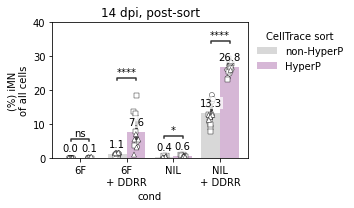

In [18]:
# General plotting params
x = 'cond'
y = 'percent'
hue = 'CT_cat'
units = 'well'
cond_list = ['6F', '6FDDRR', 'NIL', 'NILDDRR']
hue_order = ['non-CT-low', 'CT-low']
colormap = {'bulk': 'teal',
            'CT-low': '#8b0288',
            'non-CT-low': 'grey'}
marker_list = ['o', 's', '^', 'D']

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))

# Plot iMN yield per MEF plated
g = sns.barplot(
    ax=ax, data=data_iMN_percent_reps,
    x=x, y=y, hue=hue, units=units,
    order=cond_list, hue_order=hue_order,
    palette=colormap, alpha=0.3)
for (i, rep) in enumerate(data_iMN_percent_reps.replicate.unique()):
    sns.stripplot(ax=ax, data=data_iMN_percent_reps.loc[(data_iMN_percent_reps.replicate == rep)],
        x=x, y=y, order=cond_list, hue=hue, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'CT-low': 'white', 'non-CT-low': 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)

# Pairs for stats comp
pairs = [((cond, 'CT-low'), (cond, "non-CT-low")) for cond in cond_list]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=data_iMN_percent_reps,
    x=x, y=y, pairs=pairs, hue=hue, order=cond_list, hue_order=hue_order)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.15)

# Format
plt.title('14 dpi, post-sort')
ax.yaxis.set_label_text('(%) iMN\nof all cells')
ax.set_yticks(np.arange(0, 50, 10))

ax.set_xticklabels(['6F', '6F\n+ DDRR', 'NIL', 'NIL\n+ DDRR'])

# Adjust labels
lmap = {'CT-low':'HyperP', 'non-CT-low':'non-HyperP', 'bulk': 'bulk'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='CellTrace sort', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# plt.savefig(figpath + 'iMN_percent_eGFP_byHyperP.svg', bbox_inches='tight')

### Look at iMN yield

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

6FDDRR_non-CT-low vs. 6FDDRR_CT-low: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:4.079e-03 Stat=-3.427e+00
6F_non-CT-low vs. 6F_CT-low: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:2.531e-01 Stat=-1.581e+00
NIL_non-CT-low vs. NIL_CT-low: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:5.749e-03 Stat=-

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


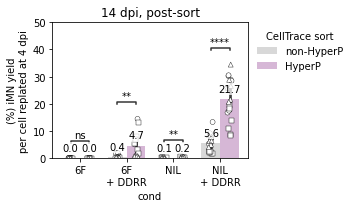

In [ ]:
# General plotting params
x = 'cond'
y = 'yield'
hue = 'CT_cat'
cond_list = ['6F', '6FDDRR', 'NIL', 'NILDDRR']
hue_order = ['non-CT-low', 'CT-low']
colormap = {'bulk': 'teal',
            'CT-low': '#8b0288',
            'non-CT-low': 'grey'}

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))

# Plot iMN yield per MEF plated
g = sns.barplot(
    ax=ax, data=data_iMN_yield_reps,
    x=x, y=y, hue=hue, units=units,
    order=cond_list, hue_order=hue_order,
    palette=colormap, alpha=0.3)
for (i, rep) in enumerate(data_iMN_yield_reps.replicate.unique()):
    sns.stripplot(ax=ax, data=data_iMN_yield_reps.loc[(data_iMN_yield_reps.replicate == rep)],
        x=x, y=y, order=cond_list, hue=hue, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'CT-low': 'white', 'non-CT-low': 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)


# Pairs for stats comp
pairs = [((cond, 'CT-low'), (cond, "non-CT-low")) for cond in cond_list]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=data_iMN_yield_reps,
    x=x, y=y, pairs=pairs, hue=hue, order=cond_list, hue_order=hue_order)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.15)

# Format
plt.title('14 dpi, post-sort')
ax.yaxis.set_label_text('(%) iMN yield\nper cell replated at 4 dpi')
ax.set_yticks(np.arange(0, 51, 10))
ax.set_xticklabels(['6F', '6F\n+ DDRR', 'NIL', 'NIL\n+ DDRR'])

# Adjust labels
lmap = {'CT-low':'HyperP', 'non-CT-low':'non-HyperP', 'bulk': 'bulk'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='CellTrace sort', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# plt.savefig(figpath + 'iMN_yield_eGFP_byHyperP.svg', bbox_inches='tight')

# 14 dpi morphology

## Load data

In [22]:
# Directories
df_morph = pd.read_excel(rd.datadir/'2024.09.25_analysis.xlsx', sheet_name='final') 
df_morph.loc[:, 'percent_iMN'] = df_morph.loc[:, 'num_iMN'] / df_morph.loc[:, 'num_total']*100

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

non-HyperP vs. HyperP: t-test independent samples, P_val:6.289e-03 t=-5.252e+00


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


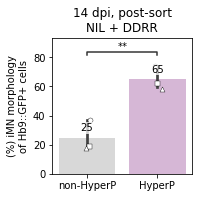

In [23]:
# What to plot
x = 'cond'
y = 'percent_iMN'
size = 'num_total'
order = ['non-HyperP', 'HyperP']

palette =  {'HyperP': '#8b0288', 'non-HyperP': 'grey'}
marker_list = ['o', 's', '^', 'D']

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

# Plot iMN yield per MEF plated
g = sns.barplot(
    ax=ax, data=df_morph,
    x=x, y=y, 
    order=order, 
    palette=palette, alpha=0.3)
for (i, rep) in enumerate(df_morph.rep.unique()):
    sns.stripplot(ax=ax, data=df_morph.loc[(df_morph.rep == rep)],
        x=x, y=y, order=order,
        dodge=True, marker=marker_list[i],
        palette={cond: 'white' for cond in order}, size=5,
        edgecolor='black', linewidth=0.4,)
    
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))
    
# Pairs for stats comp
pairs = [('HyperP', 'non-HyperP')]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=df_morph,
    x=x, y=y, pairs=pairs, order=order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

# Format
plt.title('14 dpi, post-sort\nNIL + DDRR')
ax.yaxis.set_label_text('(%) iMN morphology\nof Hb9::GFP+ cells')
ax.set_yticks(np.arange(0, 100, 20))
ax.set_xlabel('')

plt.savefig(figpath + 'iMN_morphology.svg', bbox_inches='tight')